In [4]:
import pandas as pd

df = pd.read_csv(r"C:\Users\User\Desktop\프로젝트\개인\instacart_feedback\민지\instacart_rvw_all_trans.csv")
print(type(df))         # <class 'pandas.core.frame.DataFrame'>가 떠야 정상
print(df.shape)         # (행 수, 열 수)
df.head()

<class 'pandas.core.frame.DataFrame'>
(2100, 3)


,rating,review,리뷰(번역)
0,1,The two times I have ordered and had my delive...,내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다. 어떤 이...
1,1,I have ordered 6 times using Instacart and 4 o...,"인스타카트를 통해 6번 주문했고, 그 중 4번이 문제가 있었습니다. 이번에 주문을 ..."
2,1,8 times out of 10 was terrible experience.\nLa...,10번 중 8번은 최악의 경험이었습니다. 마지막으로 쇼퍼가 아이스크림 3상자를 쿨한...
3,1,The biggest con artists around. I spent 200$ o...,가장 큰 사기꾼들. 다른 주소로 전혀 내 집이 아닌 곳으로 배달된 식료품에 200달...
4,1,Bad app company for work\nBad app company for ...,일을 위한 최악의 앱 회사\n일을 위한 최악의 앱 회사! $35의 주문을 받았는데 ...


In [15]:
df.columns

Index(['rating', 'review', '리뷰(번역)', 'filtered_tokens'], dtype='object')

In [16]:
print("전체 리뷰 수:", len(df))  #

전체 리뷰 수: 2100


In [17]:
df.rename(columns={'리뷰(번역)': '리뷰'}, inplace=True)

In [19]:
#'리뷰' 컬럼 문장분리 
import re
# 문장 단위로 분리 → explode로 행 나누기
df['sentences'] = df['리뷰'].apply(lambda x: re.split('[.!?]', x))  # 문장 단위 나누기
df = df.explode('sentences')  # 문장별로 나누기
df['sentences'] = df['sentences'].str.strip()  # 공백 제거
df = df[df['sentences'].str.len() > 3]  # 너무 짧은 문장 제거

In [20]:
# 결과 확인
df[['rating', 'sentences']].head()

,rating,sentences
0,1,내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다
0,1,어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다
0,1,운전자에게 메시지를 보내서 GPS를 사용하여 건물을 찾도록 요청했습니다 (실제 시청...
0,1,운전자는 나와 소통하다가 갑자기 응답을 멈췄습니다
0,1,그 전까지 약 25분 동안 소통했습니다


In [ ]:
#  KoNLPy의 Okt 형태소 분석기를 활용하여 문장(sentences)을 
# 형태소 분석 + 불용어 제거 + 주요 품사 필터링하는 전처리 과정
from konlpy.tag import Okt

okt = Okt()

# 불용어 예시
stopwords = ['정말', '진짜', '너무', '거의', '그냥', '좀', '것', '거', '에서', '으로', '하게', '해서']

# 토큰화 및 불용어 제거
def clean_and_tokenize(text):
    tokens = okt.pos(text, stem=True)  # 품사 정보 포함
    cleaned = [word for word, tag in tokens 
               if tag in ['Noun', 'Verb', 'Adjective'] and word not in stopwords]
    return cleaned

df_instarvw['tokens'] = df_instarvw['sentences'].apply(clean_and_tokenize)

In [47]:
negative_keywords = ['느리다', '떨어지다', '찢어지다', '불편하다', '시들다', '익다', '없다', '상하다', '더럽다', '이상하다']

# 부정 키워드 포함 여부
df['is_negative'] = df['tokens'].apply(lambda tokens: any(neg in tokens for neg in negative_keywords))

# 불만 리뷰만 따로 추출
df_negative = df[df['is_negative']]

In [ ]:

from collections import Counter

# 모든 불만 문장 토큰 합치기
all_tokens = df_negative['tokens'].explode()
token_counts = Counter(all_tokens)

# 상위 키워드 확인
token_counts.most_common(30)

[('하다', 433),
 ('없다', 378),
 ('수', 132),
 ('주문', 128),
 ('인스타', 99),
 ('카트', 99),
 ('있다', 88),
 ('배송', 55),
 ('쇼퍼', 55),
 ('더', 51),
 ('받다', 50),
 ('요청', 49),
 ('번', 47),
 ('선택', 46),
 ('때', 45),
 ('문제', 44),
 ('두', 42),
 ('되어다', 41),
 ('이다', 40),
 ('사용', 40),
 ('이상', 39),
 ('식료품', 39),
 ('물품', 38),
 ('들다', 36),
 ('서비스', 35),
 ('팁', 34),
 ('대한', 33),
 ('대체', 33),
 ('품', 33),
 ('환불', 31)]

In [49]:

# 분석에 쓸 키워드만 필터링
meaningful_keywords = [
    '주문', '환불', '쇼퍼', '상품', '서비스', '요청', '응답', '대체', '물품', '제품',
    '문제', '사용', '쇼핑'
]

df_filtered = df_negative.copy()
df_filtered['filtered_tokens'] = df_filtered['tokens'].apply(
    lambda tokens: [t for t in tokens if t in meaningful_keywords]
)


리뷰 → 문장 단위 분리 → 토큰화 + 불용어 제거 → 의미 있는 키워드만 필터링 (filtered_tokens)

In [50]:

# 환불 등 키워드가 포함된 문장만 추출
df_filtered['matched_keywords'] = df_filtered['filtered_tokens'].apply(lambda x: ', '.join(x))

# 키워드별로 어떤 문장이 있었는지 보기
for keyword in meaningful_keywords:
    print(f"\n🔍 {keyword.upper()} 관련 문장들")
    subset = df_filtered[df_filtered['filtered_tokens'].apply(lambda tokens: keyword in tokens)]
    for s in subset['sentences'].head(5):  # 상위 5개씩 예시 출력
        print("-", s)


🔍 주문 관련 문장들
- 운전자는 놀라운 일을 했지만, 고객 서비스는 무지하고 이전 밤에 지불된 주문을 해제하지 않으려고 했으며 그 안에는 전혀 처방전이 없었습니다
- 제 주문의 90%가 없다고 합니다
- 내 주소가 없다면 누가 주문을 받아서 배달을 시도하겠습니까
- 주문을 취소하고 돈을 받고 숫자에 영향을 받지 않을 수 있다고 했는데, 아무 기록도 없었습니다
- 최근 주문에서 쇼퍼가 실수를 하고 주문 및 배송을 완료할 수 없다고 말했습니다

🔍 환불 관련 문장들
- 이전에는 실수를 처리하는 데 어느 정도 능숙했고 사과나 환불/신용을 제공했는데, 이제는 그들의 형편없는 "채팅" 플랫폼을 통해 심지어 연락하기도 어렵습니다
- 주문할 때 재고가 없으면 돈을 환불하라는 상자를 명확히 체크했지만 무시되었습니다
- 이 문제를 인스타카트 고객 지원팀과 해결하려고 했지만, 체크아웃 과정 중 시스템의 잘못된 자동 청구라고 했음에도 불구하고 돈을 환불해 줄 수 없다고 했습니다
- 이런 일에 대한 환불은 없습니다
- 이전에는 실수를 처리하는 데 어느 정도 능력이 있었고 사과를 제공하거나 환불/신용을 제공했었는데, 이제는 그들의 형편없는 "채팅" 플랫폼을 통해 심지어 연락을 취하는 것조차 하느라 하느라 신이 개입해야만 합니다

🔍 쇼퍼 관련 문장들
- 최근 주문에서 쇼퍼가 실수를 하고 주문 및 배송을 완료할 수 없다고 말했습니다
- 형편없는 고객 서비스
우선 배송을 위해 추가 $5 요금을 지불했고 (30-45분), 주문을 했는데, 쇼퍼는 가게에 도착했지만 (쇼핑을 시작하지 않았음), 거의 즉시 주문 배송 시간이 거의 1시간 뒤로 변경되었습니다
- 형편없는 고객 서비스
우선 배송을 위해 추가 $5 요금을 지불했고 (30-45분), 주문을 넣었는데, 쇼퍼가 가게에 도착했지만 (쇼핑을 시작하지는 않았음), 거의 즉시 주문 배송 시간이 거의 한 시간 뒤로 변경되었습니다
- 쇼퍼 부서가 없다고 하더군요
- 대체품을 잊어버리고 쇼퍼가 도착하면 더 이상 대체품을 선택할 수 없습니다

🔍 상

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# 1. 불만 문장 벡터화
corpus = df_filtered['sentences'].tolist()
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(corpus)

# 2. 클러스터링
k = 10  # 불만 유형 5개로 가정
model = KMeans(n_clusters=k, random_state=42)
df_filtered['cluster'] = model.fit_predict(X)

# 3. 각 클러스터 대표 키워드 보기
import numpy as np
terms = vectorizer.get_feature_names_out()
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

for i in range(k):
    print(f"\n- Cluster {i} 주요 키워드:")
    for ind in order_centroids[i, :10]:
        print(terms[ind], end=', ')


- Cluster 0 주요 키워드:
없어서, 주문을, 없을, 없고, 있습니다, 매우, 정말, 없다, 고객, 없다는, 
- Cluster 1 주요 키워드:
없어요, 이상, 수가, 필요, 이제, 가치가, 쓸모가, 로그인할, 적이, 여전히, 
- Cluster 2 주요 키워드:
없다고, 말했습니다, 했습니다, 주문을, 고객, 그들은, 서비스에, 취소할, 아무것도, 합니다, 
- Cluster 3 주요 키워드:
주문할, 통해, 앱을, 없습니다, 가지고, 있는, 음식을, 없어서, 환불을, 것을, 
- Cluster 4 주요 키워드:
형편없는, 서비스, 고객, 지원, 서비스입니다, 말해서, 도움, 엉망인, 쇼퍼들은, 모두, 
- Cluster 5 주요 키워드:
없는, 있습니다, 것으로, 정말, 관련, 것은, 같습니다, 것이, 나에게, 사용할, 
- Cluster 6 주요 키워드:
전혀, 없습니다, 없었습니다, 고객, 지원이, 쓸모가, 이런, 이건, 방법이, 업데이트, 
- Cluster 7 주요 키워드:
문제가, 없었어요, 번도, 거의, 중에, 없었고, 앱에는, 문제도, 인스타카트를, 생기면, 
- Cluster 8 주요 키워드:
없습니다, 가치가, 앱을, 대한, 돈을, 있는, 적이, 방법이, 저는, 다시, 
- Cluster 9 주요 키워드:
없었습니다, 문제가, 사진을, 쓸모가, 다시, 이메일로, 해결책은, 동안, 인스타카트를, 아무것도, 

- 결과가 만족스럽지 않아서 불용어를 추가해서 정제해볼게

1. 불용어를 추가해서 정제

In [53]:
vectorizer = TfidfVectorizer(
    max_features=1000,
    stop_words=['있습니다', '없었습니다', '그들의', '했지만', '되었습니다', '계속', '대한', '없는', '그때', '또한']
)


2. 클러스터 수 줄이기 (예: 5~7)

In [54]:
k = 6
model = KMeans(n_clusters=k, random_state=42)


3. 대표 문장까지 같이 출력해서 클러스터 해석 보완

In [55]:
for i in range(k):
    print(f"\n📌 Cluster {i} 주요 키워드:")
    for ind in order_centroids[i, :10]:
        print(terms[ind], end=', ')
    
    print("\n예시 문장:")
    sample = (df_filtered[df_filtered['cluster'] == i]['sentences'].head(3)
                .drop_duplicates() #중복제거
                .head(3) #대표문장 3개만 추력
    )
    for s in sample:
        print(" -", s)



📌 Cluster 0 주요 키워드:
없어서, 주문을, 없을, 없고, 있습니다, 매우, 정말, 없다, 고객, 없다는, 
예시 문장:
 - 크레딧도 없다
 - 안타깝게도 그런 옵션이 없지만, 필요하다면 매일 이 작업을 할 것입니다
 - 처방전 약물은 전혀 없었지만, 운전자용 앱에는 신분증 확인이라고 나와 있었는데, 그것은 제 신분증이 만료되어 있고 새 카드를 기다리고 있기 때문에 작동하지 않았습니다

📌 Cluster 1 주요 키워드:
없어요, 이상, 수가, 필요, 이제, 가치가, 쓸모가, 로그인할, 적이, 여전히, 
예시 문장:
 - (그는 전화나 내 문자에 대답하지 않았고, 여기에 도착해서도 계속 "미안해요, 미안해요, 문 위의 13을 찾을 수 없어요"라고 말했습니다
 - 도와줄 수 있는 사람이 한 명도 없어요
 - 이제 최소 6시간을 기다려야 해서 식료품을 2시간 안에 받을 수 있었는데 이제 받을 수 없어요

📌 Cluster 2 주요 키워드:
없다고, 말했습니다, 했습니다, 주문을, 고객, 그들은, 서비스에, 취소할, 아무것도, 합니다, 
예시 문장:
 - 제 주문의 90%가 없다고 합니다
 - Instacart에 따르면 내 주소가 없다고 했습니다
 - 최근 주문에서 쇼퍼가 실수를 하고 주문 및 배송을 완료할 수 없다고 말했습니다

📌 Cluster 3 주요 키워드:
주문할, 통해, 앱을, 없습니다, 가지고, 있는, 음식을, 없어서, 환불을, 것을, 
예시 문장:
 - 이전에는 실수를 처리하는 데 어느 정도 능숙했고 사과나 환불/신용을 제공했는데, 이제는 그들의 형편없는 "채팅" 플랫폼을 통해 심지어 연락하기도 어렵습니다
 - 주문할 때 재고가 없으면 돈을 환불하라는 상자를 명확히 체크했지만 무시되었습니다
 - 이전에는 실수를 처리하는 데 어느 정도 능력이 있었고 사과를 제공하거나 환불/신용을 제공했었는데, 이제는 그들의 형편없는 "채팅" 플랫폼을 통해 심지어 연락을 취하는 것조차 하느라 하느라 신이 개입해야만 합니다

📌 Cluster 4 주요 키워드:

In [56]:
from gensim import corpora
from gensim.models import LdaModel

# 1. 텍스트가 토큰 리스트 형태로 준비되어 있어야 함
#  [['환불', '요청'], ['기사', '늦다'], ...]
texts = df_filtered['filtered_tokens'].tolist()

# 2. 사전 (dictionary) 생성
dictionary = corpora.Dictionary(texts)

# 3. 코퍼스 (BoW 형태) 생성
corpus = [dictionary.doc2bow(text) for text in texts]

# 4. LDA 모델 학습
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42, passes=10)


In [57]:
for i, topic in lda.show_topics(formatted=True, num_words=10):
    print(f"- Topic {i}: {topic}")


- Topic 0: 0.370*"쇼퍼" + 0.304*"쇼핑" + 0.167*"제품" + 0.144*"주문" + 0.006*"서비스" + 0.002*"상품" + 0.002*"사용" + 0.001*"환불" + 0.001*"대체" + 0.001*"문제"
- Topic 1: 0.378*"대체" + 0.372*"요청" + 0.144*"응답" + 0.068*"제품" + 0.014*"사용" + 0.006*"주문" + 0.005*"쇼퍼" + 0.003*"서비스" + 0.003*"쇼핑" + 0.002*"문제"
- Topic 2: 0.552*"문제" + 0.290*"상품" + 0.122*"물품" + 0.025*"주문" + 0.002*"쇼퍼" + 0.001*"서비스" + 0.001*"사용" + 0.001*"쇼핑" + 0.001*"응답" + 0.001*"대체"
- Topic 3: 0.530*"주문" + 0.301*"사용" + 0.162*"환불" + 0.001*"문제" + 0.001*"대체" + 0.001*"제품" + 0.001*"서비스" + 0.001*"상품" + 0.001*"쇼핑" + 0.000*"요청"
- Topic 4: 0.948*"서비스" + 0.022*"문제" + 0.012*"주문" + 0.006*"사용" + 0.002*"환불" + 0.002*"요청" + 0.001*"제품" + 0.001*"쇼핑" + 0.001*"대체" + 0.001*"물품"


앞에 숫자는 해당 **단어가 그 토픽에서 차지하는 비중(확률)**을 의미합니다.

1. LDA 토픽 분포 벡터 만들기

In [58]:
# 문서별 토픽 분포 추출
lda_vectors = []

for doc in corpus:
    topic_dist = lda.get_document_topics(doc, minimum_probability=0)
    # 토픽 비율만 추출
    vector = [prob for _, prob in topic_dist]
    lda_vectors.append(vector)

import numpy as np
X = np.array(lda_vectors)  # → (n_samples, n_topics) 형태


 2. KMeans로 클러스터링

In [59]:
from sklearn.cluster import KMeans

k = 5
model = KMeans(n_clusters=k, random_state=42)
df_filtered['topic_cluster'] = model.fit_predict(X)


In [60]:
# 클러스터별 대표 문장 보기 (중복 제거)
for i in range(k):
    print(f"\n🟡클러스터 {i} 대표 문장:")
    
    sample = (
        df_filtered[df_filtered['topic_cluster'] == i]['sentences']
        .drop_duplicates()  # ✅ 중복 제거
        .head(3)            # 대표 문장 3개만
    )
    
    for s in sample:
        print(" -", s)



🟡클러스터 0 대표 문장:
 - 운전자는 놀라운 일을 했지만, 고객 서비스는 무지하고 이전 밤에 지불된 주문을 해제하지 않으려고 했으며 그 안에는 전혀 처방전이 없었습니다
 - Instacart 고객 서비스에 여러 차례 전화했지만 문제를 해결할 수 없었어
 - 얼마나 어처구니 없는 일인지 모르겠지만 그래도 제출했지만 한 달이 지나도록 6번의 고객 서비스 전화 후에도 제 계정은 결코 잠금 해제되지 않았고, 왜 그런지도 아무도 연락해 주지 않았고 전화 상담원도 유용한 정보를 제공해 주지 않았습니다

🟡클러스터 1 대표 문장:
 - 이 문제를 인스타카트 고객 지원팀과 해결하려고 했지만, 체크아웃 과정 중 시스템의 잘못된 자동 청구라고 했음에도 불구하고 돈을 환불해 줄 수 없다고 했습니다
 - 이전에 2020년에 다쳤던 부상으로 인해 인스타카트를 사용해왔고 문제가 없었으며 서비스를 감사히 받아왔습니다
 - 주문이 배송 전용인 경우 (주류가 포함되어 있고 고객이 집에 없는 경우) 상품을 가게로 반송해야 하는 경우에는 지불되지 않습니다

🟡클러스터 2 대표 문장:
 - 크레딧도 없다
 - 안타깝게도 그런 옵션이 없지만, 필요하다면 매일 이 작업을 할 것입니다
 - 처방전 약물은 전혀 없었지만, 운전자용 앱에는 신분증 확인이라고 나와 있었는데, 그것은 제 신분증이 만료되어 있고 새 카드를 기다리고 있기 때문에 작동하지 않았습니다

🟡클러스터 3 대표 문장:
 - 제 주문의 90%가 없다고 합니다
 - 앱을 사용하지 않습니다, 작은 글꼴/타입을 볼 수 없습니다
 - 앱을 사용할 수 없

🟡클러스터 4 대표 문장:
 - 그들의 업데이트로 인해 발생하는 문제에 대해 아무도 모르고 아무도 해결할 수 없는 것과 같아요
 - 심각한 문제는 한 번도 경험해 본 적이 없어
 - 저는 기술적인 문제로 인해 기한이 지난 작업을 3번 완료했음에도 온라인으로 들어갈 수 없습니다


 각 클러스터에 자동으로 이름을 붙이는 코드

In [61]:
# 클러스터별 상위 키워드를 기반으로 이름 생성
cluster_names = {}

for cluster_num in range(k):  # k = 클러스터 수 (예: 5)
    # 해당 클러스터에 속한 리뷰 추출
    subset = df_filtered[df_filtered['topic_cluster'] == cluster_num]
    
    # 전체 토큰 모으기
    all_tokens = [token for tokens in subset['filtered_tokens'] for token in tokens]
    
    # 상위 키워드 3개 추출
    top_keywords = pd.Series(all_tokens).value_counts().head(3).index.tolist()
    
    # 슬래시로 연결해 이름 붙이기
    cluster_names[cluster_num] = " / ".join(top_keywords)

# 생성된 이름 딕셔너리 확인
print(cluster_names)

# 이름 매핑하여 새로운 컬럼에 저장
df_filtered['cluster_label'] = df_filtered['topic_cluster'].map(cluster_names)


{0: '서비스 / 사용 / 문제', 1: '문제 / 주문 / 사용', 2: '쇼퍼 / 쇼핑 / 주문', 3: '주문 / 사용 / 환불', 4: '문제 / 상품 / 물품'}


In [62]:
cluster_names

{0: '서비스 / 사용 / 문제',
 1: '문제 / 주문 / 사용',
 2: '쇼퍼 / 쇼핑 / 주문',
 3: '주문 / 사용 / 환불',
 4: '문제 / 상품 / 물품'}

- LDA + KMeans 클러스터링 후
- → 같은 클러스터에 속한 문장들끼리 정말 유사한지 확인하고 싶다!

 클러스터별 문장 간 평균 유사도 계산

In [63]:
from sklearn.metrics.pairwise import cosine_similarity

def average_cluster_similarity(X, labels):
    results = {}
    for cluster_id in np.unique(labels):
        indices = np.where(labels == cluster_id)[0] # 해당 클러스터에 속한 인덱스만
        cluster_vectors = X[indices]# 그 벡터만 추출
        
        if len(cluster_vectors) < 2:
            results[cluster_id] = 1.0  # 문서 1개면 유사도는 1로 간주
            continue

        sim_matrix = cosine_similarity(cluster_vectors)
        # 자기 자신 제외한 유사도 평균
        upper_tri = np.triu_indices_from(sim_matrix, k=1) #상삼각행렬만 추출 (중복 제거)
        avg_sim = sim_matrix[upper_tri].mean()  # 평균 유사도
        results[cluster_id] = avg_sim
    return results

# 실행
similarities = average_cluster_similarity(np.array(lda_vectors), df_filtered['topic_cluster'].values)

# 결과 출력
for cluster_id, avg_sim in similarities.items():
    print(f" - Cluster {cluster_id}: 평균 문장 유사도 = {avg_sim:.4f}")


 - Cluster 0: 평균 문장 유사도 = 0.8992
 - Cluster 1: 평균 문장 유사도 = 0.9543
 - Cluster 2: 평균 문장 유사도 = 0.8870
 - Cluster 3: 평균 문장 유사도 = 0.9769
 - Cluster 4: 평균 문장 유사도 = 0.9529


- 같은 클러스터에 속한 문장들끼리 의미적으로 유사한가?
→ 이를 수치화해서 클러스터링의 품질을 판단하는 게 목표입니다.

✅ 핵심 아이디어
- **LDA로 만든 벡터 (lda_vectors)**는 각 문장을 주제 확률 분포(벡터)로 바꾼 것
- → 예: [0.1, 0.6, 0.3] ← "이 문장은 Topic 1에 가까움"

- 같은 클러스터에 속한 문장들끼리,
- 그 LDA 벡터 간 **코사인 유사도(Cosine Similarity)**를 구함

- 그 유사도를 평균 내면:

- 해당 클러스터 내부 문장들이 얼마나 "비슷한 주제"를 가지고 있는지 수치로 판단 가능



- 0.7 이상 → 같은 주제 잘 모였다고 볼 수 있음

- 0.4 이하 → 토픽 혼합이거나 LDA 토픽 수/클러스터 수 재조정 필요

In [67]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 리스트 → 배열로 변환
lda_array = np.array(lda_vectors)

# t-SNE 적용
X_2d = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(lda_array)


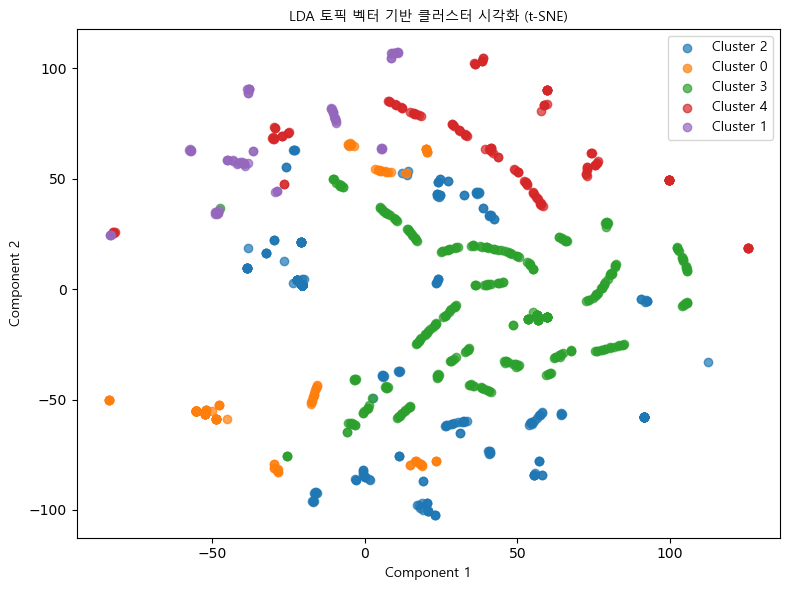

In [70]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 1. 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 2. 리스트 → NumPy 배열
lda_array = np.array(lda_vectors)

# 3. t-SNE 적용
X_2d = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(lda_array)

# 4. 시각화
plt.figure(figsize=(8, 6))
for cluster_id in df_filtered['topic_cluster'].unique():
    idx = df_filtered['topic_cluster'] == cluster_id
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=f"Cluster {cluster_id}", alpha=0.7)

plt.legend(prop=font_prop)
plt.title("LDA 토픽 벡터 기반 클러스터 시각화 (t-SNE)", fontproperties=font_prop)
plt.xlabel("Component 1", fontproperties=font_prop)
plt.ylabel("Component 2", fontproperties=font_prop)
plt.tight_layout()
plt.show()


 t-SNE 시각화 해석법 (LDA 토픽 클러스터 기준)
1. 각 점(Point)은 하나의 리뷰 문장을 의미해
점 하나 = 사용자 리뷰 하나 (혹은 TF-IDF나 LDA로 벡터화한 문장)

이 점들의 상대적 거리 = 리뷰 간 의미적 유사성

2. 비슷한 의미의 문장일수록 가까이 배치됨
같은 주제를 공유하는 문장들은 같은 클러스터 안에서 밀집

다른 주제를 가진 문장과는 거리상 분리

3. 클러스터 별 영역 구분을 통해 LDA 토픽 주제 확인
예: 파란색 Cluster 3 → “배송 불만” 관련 리뷰

주황색 Cluster 1 → “환불 처리 문제” 관련 리뷰
→ 이렇게 시각적으로 명확한 주제 영역이 잘 드러나면 LDA 결과가 유의미하다고 판단 가능

4. 군집이 서로 얼마나 멀리 떨어져 있는가?
토픽 간 명확한 구분이 존재한다는 뜻

만약 클러스터가 겹치거나 흩어져 있다면 → 주제가 애매하거나 모델 정교화 필요

5. t-SNE는 거리 간 정확한 비율을 유지하지는 않음
"거리가 2배니까 2배 더 다르다"는 의미는 아님

다만, 근접한 점들은 실제로 의미가 유사한 경우가 많음

💡 해석 예시로 써먹기 좋은 문장
“t-SNE 시각화를 통해 LDA 기반 리뷰 토픽들이 주제별로 명확히 분리됨을 확인할 수 있었고, 이는 각 사용자 불만 유형이 뚜렷하게 분류될 수 있음을 시사합니다.”

또는

“배송 지연, 환불 문제, 쇼퍼 대응 등 주요 이슈가 시각적으로 군집을 이루며 분리되어, 각 주제별 요구사항이 서로 다른 고객 경험에서 비롯됨을 확인할 수 있습니다.”

In [71]:
tsne = TSNE(n_components=2, perplexity=15, n_iter=2000, random_state=42)

- 이게 kmeans 기반 

In [72]:
from collections import Counter

# 클러스터 개수 k개일 때
for i in range(k):
    print(f"\n🧩 클러스터 {i} 주요 키워드:")
    
    # 클러스터 i에 해당하는 행 필터링 → 토큰 컬럼을 펼쳐서 리스트로 만들기
    token_list = df_filtered[df_filtered['cluster'] == i]['filtered_tokens'].explode()
    
    # 가장 많이 등장한 토큰 10개 출력
    top_keywords = Counter(token_list).most_common(10)
    print(top_keywords)



🧩 클러스터 0 주요 키워드:
[('주문', 173), ('사용', 73), ('서비스', 62), ('쇼핑', 39), ('쇼퍼', 38), ('문제', 28), ('상품', 27), ('대체', 26), ('환불', 24), ('제품', 24)]

🧩 클러스터 1 주요 키워드:
[('주문', 9), ('쇼퍼', 4), ('서비스', 4), ('환불', 4), ('사용', 3), ('물품', 3), ('쇼핑', 2), ('문제', 2), (nan, 1), (nan, 1)]

🧩 클러스터 2 주요 키워드:
[('주문', 42), ('서비스', 20), ('환불', 18), ('쇼퍼', 10), ('문제', 8), ('사용', 8), ('요청', 6), ('상품', 5), ('제품', 4), ('물품', 2)]

🧩 클러스터 3 주요 키워드:
[('주문', 33), ('환불', 8), ('상품', 5), ('요청', 2), (nan, 1), (nan, 1), ('사용', 1), (nan, 1), (nan, 1), (nan, 1)]

🧩 클러스터 4 주요 키워드:
[('서비스', 23), ('쇼퍼', 2), ('문제', 1), (nan, 1), (nan, 1), ('쇼핑', 1), ('상품', 1)]


-> kmeans했을때 조금 아쉬워서 보완할 수 있는걸 찾다가 LDA를 발견했어요

- 이게 LDA기반

In [73]:
for i in range(df_filtered['topic_cluster'].nunique()):
    print(f"\n🧩 토픽 {i} 주요 키워드:")
    token_list = df_filtered[df_filtered['topic_cluster'] == i]['filtered_tokens'].explode()
    top_keywords = Counter(token_list).most_common(10)
    print(top_keywords)



🧩 토픽 0 주요 키워드:
[('서비스', 161), ('사용', 14), ('문제', 9), ('환불', 9), ('쇼핑', 8), ('주문', 7), ('쇼퍼', 5), ('응답', 2), ('상품', 1)]

🧩 토픽 1 주요 키워드:
[('문제', 44), ('주문', 39), ('사용', 21), ('상품', 20), ('환불', 13), ('서비스', 4), ('물품', 4), ('대체', 2), ('제품', 1), ('요청', 1)]

🧩 토픽 2 주요 키워드:
[('쇼퍼', 67), ('쇼핑', 53), ('주문', 41), ('제품', 35), ('대체', 32), ('요청', 32), ('사용', 12), ('서비스', 10), ('응답', 10), ('상품', 6)]

🧩 토픽 3 주요 키워드:
[('주문', 249), ('사용', 126), ('환불', 66), ('제품', 10), ('쇼퍼', 6), ('요청', 6), ('대체', 5), ('쇼핑', 4), ('서비스', 3), ('응답', 1)]

🧩 토픽 4 주요 키워드:
[('문제', 89), ('상품', 46), ('물품', 26), ('쇼퍼', 8), ('주문', 7), ('서비스', 6), ('쇼핑', 6), ('응답', 2), ('대체', 1)]


-> 아무래도 LDA가 더 잘된거같아서 
- 그래서 기존의 KMEANS 코드를 전부 LDA로 변환시켰어요

In [74]:
# LDA 기반 topic_cluster 컬럼에 대한 라벨 매핑
topic_labels = {
    0: "📦 주문 오류 및 대체 불만\n- 주문 누락, 잘못된 대체품, 환불 미처리",
    1: "🍎 제품 문제 및 품질 불만\n- 상한 상품, 포장 불량, 품질 저하",
    2: "🛠 서비스 품질 및 사용성 문제\n- 앱 오류, 쿠폰 미적용, UI 불편",
    3: "👤 쇼퍼 응대 및 환불 문제\n- 쇼퍼 불친절, 응답 지연, 환불 지연",
    4: "📞 고객 요청 미응답\n- 요청사항 반영 안됨, 연락 두절, CS 미흡"
}


# 새로운 라벨 컬럼 추가
df_filtered['topic_label'] = df_filtered['topic_cluster'].map(topic_labels)


In [75]:
# LDA 토픽 번호에 따른 요구사항 템플릿
demand_templates_lda = {
    0: "주문 정확도 개선 및 잘못된 대체품 방지 프로세스 강화 필요",
    1: "상품 품질 관리 및 포장 상태 개선과 신속한 클레임 처리 체계 필요",
    2: "앱 기능 안정화, 할인/쿠폰 시스템 개선 및 전반적인 사용성 향상 필요",
    3: "쇼퍼 교육 표준화 및 고객 불만 대응/환불 처리 시스템 개선 필요",
    4: "고객 요청사항 실시간 반영과 대응 속도 개선을 위한 CS 시스템 필요"
}

# 데이터프레임에 라벨/요구사항 매핑
df_filtered['topic_label'] = df_filtered['topic_cluster'].map(topic_labels)
df_filtered['user_demand'] = df_filtered['topic_cluster'].map(demand_templates_lda)

# 출력 예시
for i in sorted(df_filtered['topic_cluster'].unique()):
    print(f"\n Topic {i} - {topic_labels[i]}")
    print(f" - 요구사항 요약: {demand_templates_lda[i]}")
    sample = df_filtered[df_filtered['topic_cluster'] == i]['sentences'].drop_duplicates().head(3)
    for s in sample:
        print(" -", s)




 Topic 0 - 📦 주문 오류 및 대체 불만
- 주문 누락, 잘못된 대체품, 환불 미처리
 - 요구사항 요약: 주문 정확도 개선 및 잘못된 대체품 방지 프로세스 강화 필요
 - 운전자는 놀라운 일을 했지만, 고객 서비스는 무지하고 이전 밤에 지불된 주문을 해제하지 않으려고 했으며 그 안에는 전혀 처방전이 없었습니다
 - Instacart 고객 서비스에 여러 차례 전화했지만 문제를 해결할 수 없었어
 - 얼마나 어처구니 없는 일인지 모르겠지만 그래도 제출했지만 한 달이 지나도록 6번의 고객 서비스 전화 후에도 제 계정은 결코 잠금 해제되지 않았고, 왜 그런지도 아무도 연락해 주지 않았고 전화 상담원도 유용한 정보를 제공해 주지 않았습니다

 Topic 1 - 🍎 제품 문제 및 품질 불만
- 상한 상품, 포장 불량, 품질 저하
 - 요구사항 요약: 상품 품질 관리 및 포장 상태 개선과 신속한 클레임 처리 체계 필요
 - 이 문제를 인스타카트 고객 지원팀과 해결하려고 했지만, 체크아웃 과정 중 시스템의 잘못된 자동 청구라고 했음에도 불구하고 돈을 환불해 줄 수 없다고 했습니다
 - 이전에 2020년에 다쳤던 부상으로 인해 인스타카트를 사용해왔고 문제가 없었으며 서비스를 감사히 받아왔습니다
 - 주문이 배송 전용인 경우 (주류가 포함되어 있고 고객이 집에 없는 경우) 상품을 가게로 반송해야 하는 경우에는 지불되지 않습니다

 Topic 2 - 🛠 서비스 품질 및 사용성 문제
- 앱 오류, 쿠폰 미적용, UI 불편
 - 요구사항 요약: 앱 기능 안정화, 할인/쿠폰 시스템 개선 및 전반적인 사용성 향상 필요
 - 크레딧도 없다
 - 안타깝게도 그런 옵션이 없지만, 필요하다면 매일 이 작업을 할 것입니다
 - 처방전 약물은 전혀 없었지만, 운전자용 앱에는 신분증 확인이라고 나와 있었는데, 그것은 제 신분증이 만료되어 있고 새 카드를 기다리고 있기 때문에 작동하지 않았습니다

 Topic 3 - 👤 쇼퍼 응대 및 환불 문제
- 쇼퍼 불친절, 응답 지연, 환불 지연
 -

토픽별 주요 키워드 워드클라우드 만들기

C:\Users\User\AppData\Local\Temp\ipykernel_4580\1589450568.py:43: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


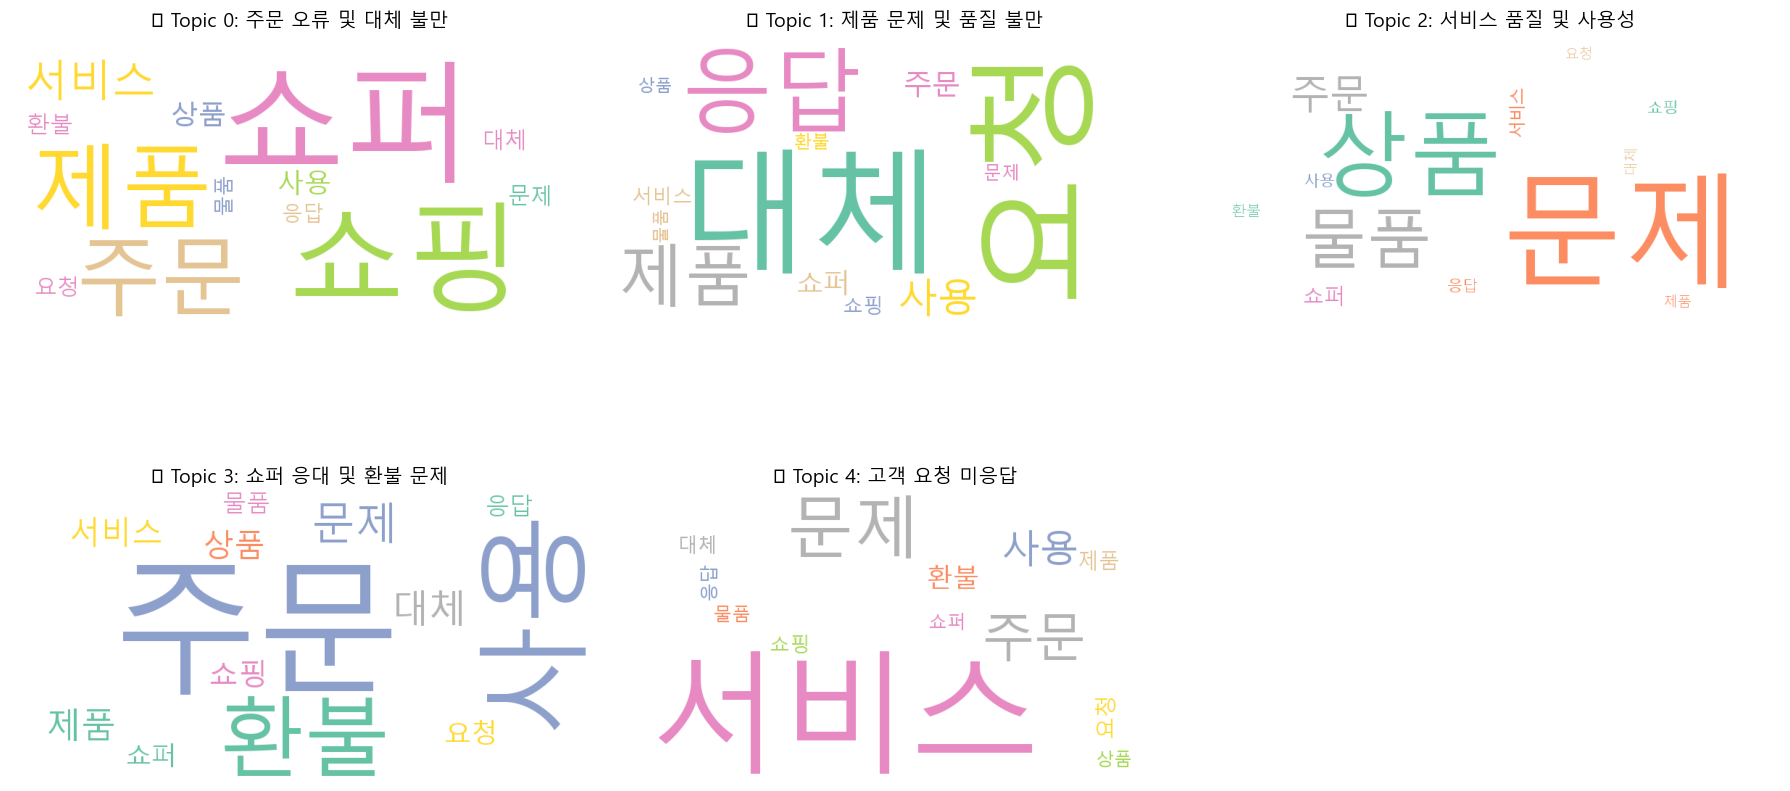

In [76]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 주제명 매핑
topic_labels = {
    0: "주문 오류 및 대체 불만",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}

# 시각화 설정
n_topics = len(topic_labels)
ncols = 3
nrows = (n_topics + ncols - 1) // ncols

plt.figure(figsize=(18, 10))

for i, (topic_id, topic) in enumerate(lda.show_topics(formatted=False, num_words=20)):
    words = dict(topic)
    wc = WordCloud(font_path=font_path, background_color="white", width=800, height=400)

   
    wc = WordCloud(
        font_path=font_path,
        background_color="white",
        colormap= 'Set2',
        width=800,
        height=400
    )

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(wc.generate_from_frequencies(words))
    plt.axis('off')
    title_text = f"🧩 Topic {topic_id}: {topic_labels.get(topic_id, 'Unknown')}"
    plt.title(title_text, fontproperties=font_prop, fontsize=14)

plt.tight_layout()
plt.show()


-> 이정도면 워드클라우드도 토픽별로 잘나오는것 같다고 판단했어요

LDA 기반 사용자 요구사항 빈도 시각화 코드

C:\Users\User\AppData\Local\Temp\ipykernel_4580\171052289.py:24: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
c:\Users\User\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


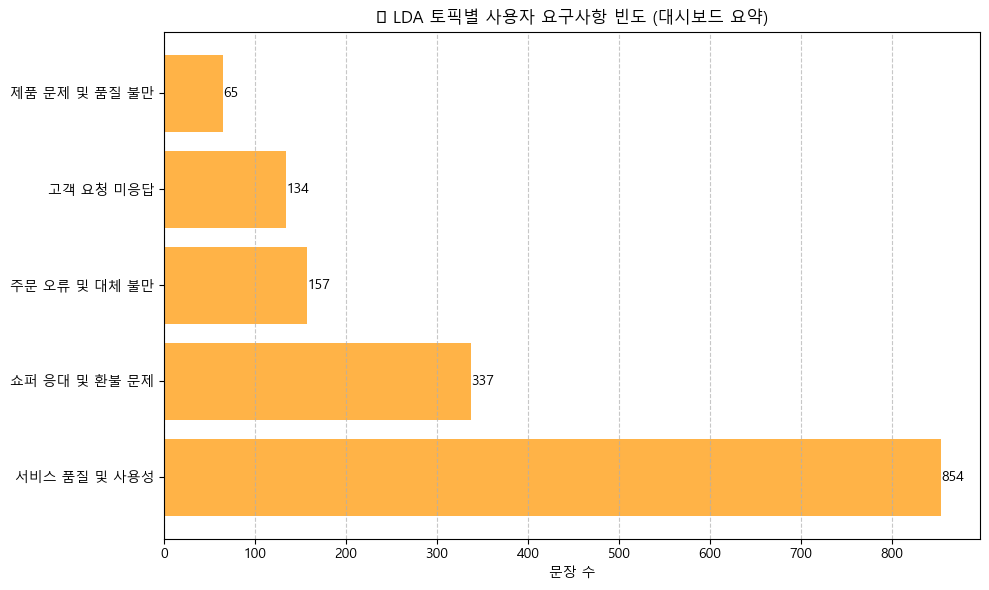

In [77]:
import matplotlib.pyplot as plt

# 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'

# ✅ LDA 기반 문장 수 요약 테이블
lda_summary = df_filtered['topic_cluster'].map(topic_labels).value_counts().reset_index()
lda_summary.columns = ['토픽 주제', '문장 수']
lda_summary = lda_summary.sort_values('문장 수')  # y축 뒤집기용

# ✅ 수평 막대그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.barh(lda_summary['토픽 주제'], lda_summary['문장 수'], color="#FFB347")
plt.xlabel("문장 수")
plt.title("📊 LDA 토픽별 사용자 요구사항 빈도 (대시보드 요약)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# ✅ 바 라벨 추가
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             f"{int(bar.get_width())}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [79]:
print("전체 리뷰 수:", len(df))  # 원본 전체 리뷰 수
print("LDA 사용 리뷰 수:", len(df_filtered))  # LDA에 사용한 필터된 수

전체 리뷰 수: 11104
LDA 사용 리뷰 수: 1547


-> 차이가 왜 나는지 궁금해서 확인해보니까 
LDA로 필터링할때 
1. 공백 리뷰 제거 (0개)
2. 짧은 리뷰 제거 
3. 의미 없는 토큰만 남은 리뷰 제거
4. 오류 리뷰 제거 (인코딩실패같은)
5. 특정 기준 키워드 없는 리뷰 제거하다보니 383개로 줄여진거같아요,,,

LDA 기반 클러스터별 키워드 빈도 분석 코드

- topic_labels 
    - 0: "📦 주문 오류 및 대체 불만\n- 주문 누락, 잘못된 대체품, 환불 미처리",
    - 1: "🍎 제품 문제 및 품질 불만\n- 상한 상품, 포장 불량, 품질 저하",
    - 2: "🛠 서비스 품질 및 사용성 문제\n- 앱 오류, 쿠폰 미적용, UI 불편",
    - 3: "👤 쇼퍼 응대 및 환불 문제\n- 쇼퍼 불친절, 응답 지연, 환불 지연",
    - 4: "📞 고객 요청 미응답\n- 요청사항 반영 안됨, 연락 두절, CS 미흡"


In [80]:
from collections import Counter
import pandas as pd
from collections import defaultdict

# 👉 사전 작업: LDA 기준으로 키워드 수집
lda_keywords = defaultdict(list)

for _, row in df_filtered.iterrows():
    lda_keywords[row['topic_cluster']].extend(row['filtered_tokens'])

# 클러스터별 핵심 키워드 TOP 5 추출
top_keywords_per_topic = []

for topic_id, tokens in lda_keywords.items():
    counter = Counter(tokens)
    top_keywords = counter.most_common(5)
    for keyword, count in top_keywords:
        top_keywords_per_topic.append({
            '토픽': topic_id,
            '키워드': keyword,
            '등장 횟수': count
        })

# ✅ 최종 데이터프레임 생성
df_top_keywords_lda = pd.DataFrame(top_keywords_per_topic)
df_top_keywords_lda


,토픽,키워드,등장 횟수
0,2,쇼퍼,67
1,2,쇼핑,53
2,2,주문,41
3,2,제품,35
4,2,대체,32
5,0,서비스,161
6,0,사용,14
7,0,문제,9
8,0,환불,9
9,0,쇼핑,8


In [82]:
# 이미 정의한 수작업 토픽명 매핑을 복사해서 topic_names로 저장
topic_names = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "원치 않는 대체상품 문제",
    2: "상품 파손 및 신선도 불만",
    3: "쇼퍼의 태도 및 커뮤니케이션 문제",
    4: "앱/서비스 오류 및 사용성 문제"
}

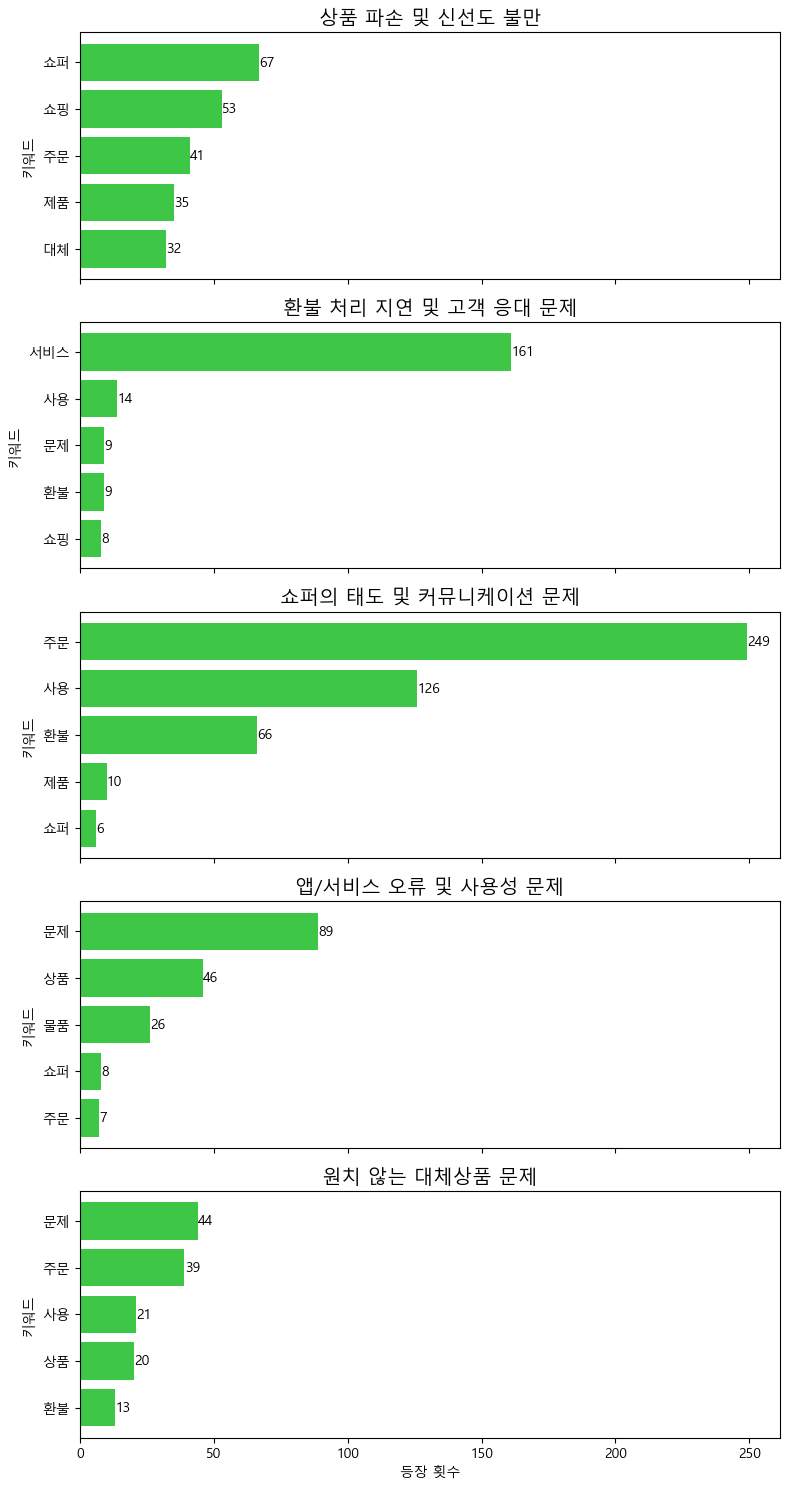

In [83]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정 (Windows용)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 📌 데이터프레임: LDA 기반 키워드 데이터
clusters = df_top_keywords_lda['토픽'].unique()
num_clusters = len(clusters)

fig, axes = plt.subplots(num_clusters, 1, figsize=(8, 3 * num_clusters), sharex=True)

# subplot이 하나인 경우도 리스트 처리
if num_clusters == 1:
    axes = [axes]

# 각 subplot 그리기
for i, topic_id in enumerate(clusters):
    data = df_top_keywords_lda[df_top_keywords_lda['토픽'] == topic_id]
    bars = axes[i].barh(data['키워드'], data['등장 횟수'], color="#3EC647")
    
    # 제목을 매핑된 토픽명으로 지정
    axes[i].set_title(f"{topic_names.get(topic_id, f'Topic {topic_id}')}", fontproperties=font_prop, fontsize=14)
    axes[i].set_ylabel("키워드", fontproperties=font_prop)
    axes[i].invert_yaxis()

    # 숫자 레이블 추가
    for bar in bars:
        width = bar.get_width()
        axes[i].text(width + 0.1, bar.get_y() + bar.get_height() / 2,
                     f"{int(width)}", va='center', fontsize=10, color='black')

# 마지막 x축 레이블만 추가
axes[-1].set_xlabel("등장 횟수", fontproperties=font_prop)

plt.tight_layout()
plt.show()


리뷰 별점에 큰 영향을 주는 핵심 요인들(예: 환불, 응대, 쇼퍼 태도, 대체품 문제 등)

In [84]:
# 영향 요인 정의 (핵심 변수 정의)
impact_factors = {
    "쇼퍼 태도": ["shopper", "쇼퍼", "불친절", "느림", "대응", "경험"],
    "환불 문제": ["환불", "취소", "불가", "지연", "기록 없음"],
    "응대 부족": ["응대", "답변", "연락 없음", "고객센터", "응답"],
    "대체품 문제": ["대체", "대신", "선택", "최악", "맘에 안듦"],
    "상품 상태": ["상하다", "썩다", "찌그러짐", "파손", "깨짐", "문제", "냄새"]
}


LDA 토픽별 영향 요인 문장 추출 코드

In [85]:
from collections import defaultdict

lda_issue_sentences = defaultdict(lambda: defaultdict(set))  # ✅ set으로 중복 제거

for _, row in df_filtered.iterrows():
    topic_id = row['topic_cluster']
    sentence = row['sentences']
    for factor, keywords in impact_factors.items():
        if any(kw in sentence for kw in keywords):
            lda_issue_sentences[topic_id][factor].add(sentence)  # ✅ 중복 방지


각 토픽별 요인별 대표 문장

In [86]:
import pandas as pd

# 데이터를 표로 변환할 리스트
rows = []

# 토픽-요인별 대표 문장 추출
for topic_id, factor_dict in lda_issue_sentences.items():
    for factor, sents in factor_dict.items():
        for s in list(sents)[:3]:  # 대표 문장 최대 3개까지
            rows.append({
                "토픽 번호": topic_id,
                "주요 영향 요인": factor,
                "대표 문장": s
            })

# DataFrame으로 변환
df_lda_factors = pd.DataFrame(rows)

# 보기 쉽게 정렬 (선택사항)
df_lda_factors = df_lda_factors.sort_values(by=["토픽 번호", "주요 영향 요인"])
df_lda_factors.head(3)

,토픽 번호,주요 영향 요인,대표 문장
17,0,대체품 문제,고객 서비스가 쓸모 없고 최악이었습니다
18,0,대체품 문제,제 인생에서 인스타카트와 함께한 최악의 고객 서비스를 경험해 본 적이 없습니다
19,0,대체품 문제,제 인생에서 인스타카트와 함께 한 최악의 고객 서비스를 경험해 본 적이 없습니다


- 주제 잡고 다시 해볼게

| 대분류      | 세부 유형 (불만 유형 확장 예시)      |
| -------- | ------------------------ |
| 주문 문제    | 주문 실패 / 누락 / 지연 / 잘못된 제품 |
| 배송 문제    | 배송 지연 / 배송 중 파손 / 쇼퍼 실수  |
| 대체품 문제   | 고객 동의 없이 대체 / 품질 낮은 대체품  |
| 환불·CS 문제 | 환불 지연 / 응답 없음 / 고객 응대 문제 |
| 상품 품질 문제 | 상함 / 찢어짐 / 유통기한 문제       |
| 쿠폰·결제    | 쿠폰 미적용 / 결제 오류           |


-> 이렇게 확장시키기

In [88]:
from konlpy.tag import Okt
okt = Okt()

def clean_and_tokenize(text):
    # 예시: 명사 추출 + 불용어 제거
    stopwords = ['정말', '진짜', '너무', '거의', '그냥', '좀', '것', '거', '에서', '으로', '하게', '해서']
    tokens = okt.nouns(text)
    tokens = [word for word in tokens if word not in stopwords and len(word) > 1]
    return tokens

# 적용
df['filtered_tokens'] = df['리뷰'].apply(clean_and_tokenize)
from konlpy.tag import Okt
okt = Okt()
def tokenize(text):
    return [w for w, pos in okt.pos(text) if pos in ['Noun', 'Adjective']]


In [89]:
df_filtered = df[df['filtered_tokens'].apply(lambda x: len(x) > 2)].copy()

In [90]:
print("전체 리뷰 수:", len(df))
print("전처리 후 리뷰 수:", len(df_filtered))
print("필터링 비율:", 100 - len(df_filtered)/len(df)*100, "%")


전체 리뷰 수: 11104
전처리 후 리뷰 수: 11104
필터링 비율: 0.0 %


In [91]:
print(df_filtered.columns)

Index(['rating', 'review', '리뷰', 'filtered_tokens', 'sentences', 'tokens',
       'is_negative'],
      dtype='object')


In [94]:
from gensim import models

# 예: 토픽 수 5개로 설정
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=10
)

In [95]:
# 문서별 토픽 분포 구하기
lda_vectors = [lda_model.get_document_topics(bow, minimum_probability=0) for bow in corpus]

# NumPy 배열 변환
import numpy as np
lda_vectors = np.array([
    [prob for _, prob in doc]
    for doc in lda_vectors
])

# 토픽 할당
df_filtered = df_filtered.iloc[:len(lda_vectors)].copy()
df_filtered['topic_cluster'] = np.argmax(lda_vectors, axis=1)


In [96]:
df_filtered = df_filtered.iloc[:len(lda_vectors)].copy()
df_filtered['topic_cluster'] = np.argmax(lda_vectors, axis=1)

In [97]:
len(lda_vectors)

1547

In [98]:
from konlpy.tag import Okt

okt = Okt()

def tokenize(text):
    return okt.nouns(text)  # 명사만 추출하거나 okt.morphs(text) 도 가능

df['filtered_tokens'] = df['리뷰'].fillna('').apply(tokenize)


In [99]:
#  KoNLPy의 Okt 형태소 분석기를 활용하여 문장(sentences)을 
# 형태소 분석 + 불용어 제거 + 주요 품사 필터링하는 전처리 과정
from konlpy.tag import Okt

okt = Okt()

# 불용어 예시
stopwords = ['정말', '진짜', '너무', '거의', '그냥','입니다', '있는', '하고', '해서', '하면', '정도'
             , '좀', '것', '거', '에서', '하다','이다' ,'더','있다','으로', '하게']

# 토큰화 및 불용어 제거
def clean_and_tokenize(text):
    tokens = okt.pos(text, stem=True)  # 품사 정보 포함
    cleaned = [word for word, tag in tokens 
               if tag in ['Noun', 'Verb', 'Adjective'] and word not in stopwords]
    return cleaned

df['tokens'] = df['sentences'].apply(clean_and_tokenize)

In [100]:
from collections import Counter

# 부정 리뷰 토큰 전체 펼치기
all_tokens = df_filtered['filtered_tokens'].explode()
token_counts = Counter(all_tokens)

# 상위 키워드 확인
print(token_counts.most_common(20))

[('주문', 2438), ('인스타', 1235), ('카트', 1218), ('서비스', 1114), ('고객', 842), ('사용', 807), ('문제', 746), ('배달', 680), ('취소', 667), ('쇼퍼', 650), ('시간', 615), ('전화', 579), ('배송', 537), ('환불', 519), ('다시', 478), ('청구', 472), ('위해', 460), ('동안', 453), ('계정', 416), ('채팅', 410)]


In [101]:
print(df_filtered.columns.tolist())

['rating', 'review', '리뷰', 'filtered_tokens', 'sentences', 'tokens', 'is_negative', 'topic_cluster']


In [102]:
# 1. impact_factors 정의 (이미 있으시면 생략 가능)
impact_factors = {
    "상품 상태": [
        "상하다", "썩다", "찌그러짐", "파손", "깨짐", "불량", "냄새", "상태", "신선", "포장", "문제", "변질", "누락"
    ],
    "대체품 문제": [
        "대체", "대신", "잘못된", "다른", "원하지", "선택", "엉뚱한", "최악", "맘에 안듦", "마음에 들지 않음"
    ],
    "환불 문제": [
        "환불", "지연", "취소", "불가", "기록 없음", "못 받음", "안 됨", "누락", "환불 안됨", "환불되지 않음"
    ],
    "쇼퍼 태도": [
        "쇼퍼", "shopper", "불친절", "느림", "대응", "태도", "무시", "연락", "경험", "대화", "무반응"
    ],
    "응대 부족": [
        "응대", "답변", "연락 없음", "고객센터", "응답 없음", "연결 안됨", "응답", "연락두절"
    ],
    "서비스 전반": [
        "늦다", "느림", "연결", "응답 없음", "불편", "문제", "버그", "이용 불편", "접속 오류", "로그인 문제"
    ]
}

# 2. 일반 키워드 정의
general_keywords = [
    "주문", "환불", "쇼퍼", "상품", "서비스", "요청", "응답", 
    "대체", "물품", "제품", "문제", "사용", "쇼핑"
]

# 3. impact_factors와 general_keywords 합쳐서 all_keywords 생성
all_keywords = set(general_keywords)
for keywords in impact_factors.values():
    all_keywords.update(keywords)


In [43]:
for keyword in all_keywords:  # all_keywords는 의미 있는 키워드들
    print(f"\n🔍 {keyword.upper()} 관련 문장들")
    
    subset = df_filtered[df_filtered['filtered_tokens'].apply(lambda tokens: keyword in tokens)]
    
    for s in subset['리뷰(번역)'].head(5):  # ✅ 'sentences' → '리뷰(번역)'로 수정
        print("-", s)



🔍 불친절 관련 문장들

🔍 연락두절 관련 문장들

🔍 환불 안됨 관련 문장들

🔍 상품 관련 문장들
- 정말 정말 정말 최악이었습니다. 피가 섞인 고기가 모든 것과 섞여 있었습니다. 채소에 비누가 섞여 있었습니다. 할인 상품은 할인되지 않았거나 품절이었습니다. 소통이 전혀 되지 않았습니다. 100달러 주문에 팁을 주었는데, 모든 무거운 물품이 품절이었고 실제로 받은 장보기는 70달러 밖에 안 되었습니다. 앱을 삭제했습니다. 다시는 이용하지 않을 것입니다.
- 쓰레기
쓰레기. 이것은 고급 서비스여야 합니다. 주문한 각 상품에 더 높은 가격을 지불합니다. 배송비와 팁을 지불합니다. 우선 배송을 위해 추가 비용을 지불합니다. 우선 수수료는 아무런 의미가 없습니다. 쇼퍼들은 선택한 상품에 전혀 신경을 쓰지 않습니다. 종종 쇼퍼들은 상품을 환불하거나 선택한 상품과 전혀 다른 대체품을 선택합니다. 인스타카트가 처음 시작했을 때는 그렇게 나쁘지 않았습니다. 그러나 지속적으로 퇴보해왔습니다. 우리는 모두 인스타카트를 망치기 위해 새로운 회사가 나타나기를 기다리고 있습니다.
- IC는 구매자들을 이용하고 있습니다.
이 회사는 구매자와 고객을 이용하고 있습니다. 이 리뷰는 구매자를 기반으로 작성하겠습니다. IC는 고객이 구매자에게 팁을 주는 것에 의존하고 있습니다. 그러나 팁은 필수 요소가 아닙니다. IC의 배치 지불은 노예 임금입니다. IC는 배달 거리에 대한 제한이 없거나 팁에 대한 고정 요금이 없습니다. 배송 주소는 숨겨져 있고 지도상의 대략적인 위치만 표시됩니다. 이러한 배송 중 일부는 더러운 길이나 자갈길을 운전해야 하는 '오프 그리드'입니다. 주문이 배송 전용인 경우 (주류가 포함되어 있고 고객이 집에 없는 경우) 상품을 가게로 반송해야 하는 경우에는 지불되지 않습니다. 인증 시스템은 결함이 있어 구매자를 몇 주 동안 추방합니다. 구매자들은 고객 서비스 도움을 기다리는 동안 대기 시간이 길어지며, 채팅이 도움 없이 종료되거나 전화가 전화량 때문에 선택할 수 없는 

In [104]:
meaningful_keywords = {
    "상품 상태": [
        "상하다", "썩다", "찌그러짐", "파손", "깨짐", "불량", "냄새", "상태", "신선", "포장", "문제", "변질", "누락"
    ],
    "대체품 문제": [
        "대체", "대신", "잘못된", "다른", "원하지", "선택", "엉뚱한", "최악", "맘에 안듦", "마음에 들지 않음"
    ],
    "환불 문제": [
        "환불", "지연", "취소", "불가", "기록 없음", "못 받음", "안 됨", "누락", "환불 안됨", "환불되지 않음"
    ],
    "쇼퍼 태도": [
        "쇼퍼", "shopper", "불친절", "느림", "대응", "태도", "무시", "연락", "경험", "대화", "무반응"
    ],
    "응대 부족": [
        "응대", "답변", "연락 없음", "고객센터", "응답 없음", "연결 안됨", "응답", "연락두절"
    ],
    "서비스 전반": [
        "늦다", "느림", "연결", "응답 없음", "불편", "문제", "버그", "이용 불편", "접속 오류", "로그인 문제"
    ]
}


In [105]:
# 1. LDA 결과 컬럼: 'topic_cluster'와 'sentences'는 이미 있을 거예요

# 2. 수작업 분류: impact_factors 기반 분류 추가
def assign_primary_category(tokens):
    for category, keywords in meaningful_keywords.items():
        if any(k in tokens for k in keywords):
            return category
    return "기타"

df_filtered['primary_category'] = df_filtered['filtered_tokens'].apply(assign_primary_category)


In [ ]:
from gensim import corpora, models

# 1. 토큰 리스트
texts = df_filtered['filtered_tokens'].tolist()

# 2. 단어 사전 생성
dictionary = corpora.Dictionary(texts)

# 3. 문서-단어 행렬 (BoW)
corpus = [dictionary.doc2bow(text) for text in texts]

# 4. LDA 모델 훈련
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=5, random_state=42)

# 5. 문장별 토픽 할당
def get_topic_id(doc_bow):
    topics = lda_model.get_document_topics(doc_bow)
    return sorted(topics, key=lambda x: -x[1])[0][0] if topics else -1

df_filtered['topic_cluster'] = [get_topic_id(doc) for doc in corpus]

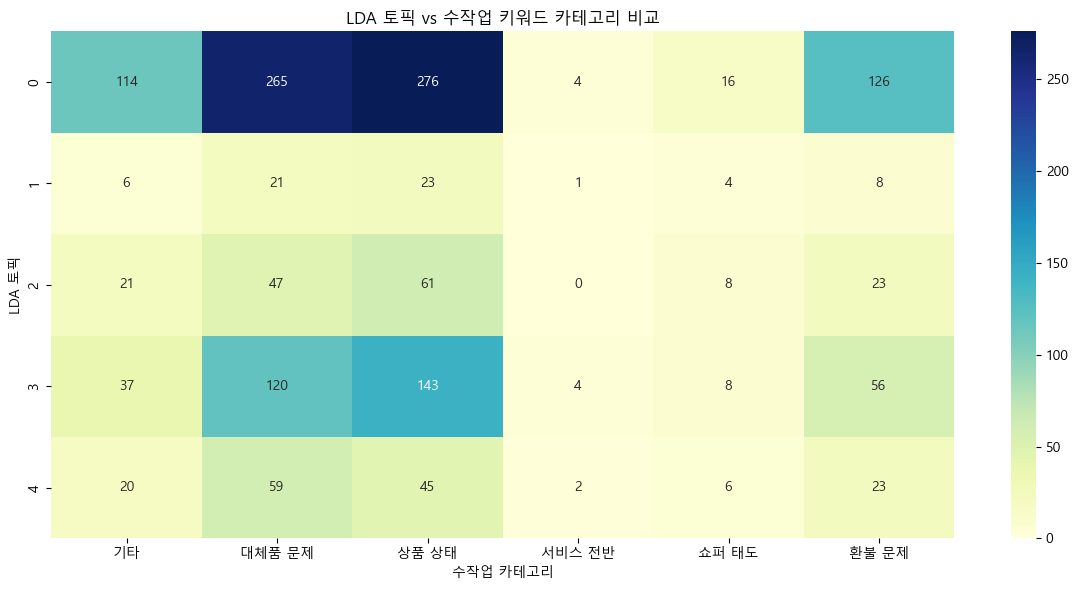

In [106]:
# 교차표
comparison_table = pd.crosstab(df_filtered['topic_cluster'], df_filtered['primary_category'])

# 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(comparison_table, annot=True, fmt='d', cmap="YlGnBu")
plt.title("LDA 토픽 vs 수작업 키워드 카테고리 비교")
plt.xlabel("수작업 카테고리")
plt.ylabel("LDA 토픽")
plt.tight_layout()
plt.show()


-> 수작업보단 LDA토픽이 더 잘나옴

- LDA 키워드 확인

In [107]:
# LDA 토픽 대표 키워드 출력
for i, topic in lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    keywords = ", ".join([word for word, _ in topic])
    print(f"🧠 Topic {i}: {keywords}")


🧠 Topic 0: 쇼퍼, 쇼핑, 제품, 주문, 서비스, 상품, 사용, 환불, 대체, 문제
🧠 Topic 1: 대체, 요청, 응답, 제품, 사용, 주문, 쇼퍼, 서비스, 쇼핑, 문제
🧠 Topic 2: 문제, 상품, 물품, 주문, 쇼퍼, 서비스, 사용, 쇼핑, 응답, 대체
🧠 Topic 3: 주문, 사용, 환불, 문제, 대체, 제품, 서비스, 상품, 쇼핑, 요청
🧠 Topic 4: 서비스, 문제, 주문, 사용, 환불, 요청, 제품, 쇼핑, 대체, 물품


토픽이랑 해석 매칭시키기

In [108]:
# 1. 토픽 번호에 따른 해석된 라벨 정의
topic_label_map = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "원치 않는 대체상품 문제",
    2: "상품 파손 및 신선도 불만",
    3: "쇼퍼의 태도 및 커뮤니케이션 문제",
    4: "앱/서비스 오류 및 사용성 문제"
}

# 2. 매핑하여 새로운 컬럼 추가
df_filtered['topic_label'] = df_filtered['topic_cluster'].map(topic_label_map)


In [109]:
# 중복 문장 제거용 집합
seen_sentences = set()

# 토픽별 문장 출력
for topic_id in sorted(df_filtered['topic_cluster'].unique()):
    # 해당 토픽의 라벨 가져오기
    topic_name = df_filtered[df_filtered['topic_cluster'] == topic_id]['topic_label'].iloc[0]

    print(f"\n📌 [Topic {topic_id}] {topic_name} ")

    # 중복 제거된 문장만 추출
    topic_sentences = df_filtered[df_filtered['topic_cluster'] == topic_id]['sentences'].drop_duplicates()

    count = 0
    for sent in topic_sentences:
        if sent not in seen_sentences:
            print("-", sent)
            seen_sentences.add(sent)
            count += 1
        if count >= 3:
            break



📌 [Topic 0] 환불 처리 지연 및 고객 응대 문제 
- 내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다
- 어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다
- 운전자에게 메시지를 보내서 GPS를 사용하여 건물을 찾도록 요청했습니다 (실제 시청 건물)

📌 [Topic 1] 원치 않는 대체상품 문제 
- 처방전 약물은 전혀 없었지만, 운전자용 앱에는 신분증 확인이라고 나와 있었는데, 그것은 제 신분증이 만료되어 있고 새 카드를 기다리고 있기 때문에 작동하지 않았습니다
- 하지만 이제 CS가 닫을 수 없는 계정이 생겼습니다
- 오늘은 마지막으로, 그 사람은 내 주차장을 6번 정도 지나가고, 내가 소리쳐도, 크게 휘파람을 불어도, 그를 20번이나 부르고도 계속 운전했습니다

📌 [Topic 2] 상품 파손 및 신선도 불만 
- 거부했고, 4명과 대화한 끝에 오후를 낭비한 끝에 Kroger 본사에서 환불을 받았습니다
- 마지막으로 쇼퍼가 아이스크림 3상자를 쿨한 온도에 넣지 않아서 $120짜리 쇼핑이 완전히 녹아버린 아이스크림으로 망가졌습니다
- 제 주문의 90%가 없다고 합니다

📌 [Topic 3] 쇼퍼의 태도 및 커뮤니케이션 문제 
- 그 전까지 약 25분 동안 소통했습니다
- Instacart에 여러 차례 연락했지만, 팁은 환불되지 않을 것이라고 알려주었습니다
- 나는 다시는 Instacart를 사용하지 않을 것이며, 친구, 가족 및 동료들에게 Instacart의 불만족스러운 고객 서비스와 주문을 받지 못할 가능성에 대해 알리고 있습니다

📌 [Topic 4] 앱/서비스 오류 및 사용성 문제 
- 운전자는 나와 소통하다가 갑자기 응답을 멈췄습니다
- $18 환불을 요청했지만 무시당했습니다
- 나는 모든 리뷰와 항소 과정을 거쳤지만 아무것도 받지 못했다


-> 라벨링 매칭 시켰는데 잘 매칭 됐는지 확인하고 자동매칭으로 하면 얼마나 정확한지 비교하는거

In [110]:
for i, topic in lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    keywords = ", ".join([word for word, _ in topic])
    print(f"🧠 Topic {i}: {keywords}")


🧠 Topic 0: 쇼퍼, 쇼핑, 제품, 주문, 서비스, 상품, 사용, 환불, 대체, 문제
🧠 Topic 1: 대체, 요청, 응답, 제품, 사용, 주문, 쇼퍼, 서비스, 쇼핑, 문제
🧠 Topic 2: 문제, 상품, 물품, 주문, 쇼퍼, 서비스, 사용, 쇼핑, 응답, 대체
🧠 Topic 3: 주문, 사용, 환불, 문제, 대체, 제품, 서비스, 상품, 쇼핑, 요청
🧠 Topic 4: 서비스, 문제, 주문, 사용, 환불, 요청, 제품, 쇼핑, 대체, 물품


In [111]:
# topic 키워드가 어떤 카테고리 키워드랑 가장 많이 겹치는지 자동 매핑
def guess_label_from_keywords(topic_keywords, impact_dict):
    scores = {}
    for label, keywords in impact_dict.items():
        # 얼마나 많이 겹치는지 스코어 계산
        score = sum(1 for word in topic_keywords if word in keywords)
        scores[label] = score

    # 가장 많이 겹친 라벨 반환 (없으면 '기타')
    best_label = max(scores, key=scores.get)
    return best_label if scores[best_label] > 0 else "기타"



In [112]:
# 토픽 번호 -> 대표 키워드 추출
lda_topic_labels = {}

for topic_id, topic in lda_model.show_topics(num_topics=5, num_words=10, formatted=False):
    topic_keywords = [word for word, _ in topic]
    label = guess_label_from_keywords(topic_keywords, impact_factors)
    lda_topic_labels[topic_id] = label
    print(f"🧠 Topic {topic_id}: {', '.join(topic_keywords)} → 📌 {label}")


🧠 Topic 0: 쇼퍼, 쇼핑, 제품, 주문, 서비스, 상품, 사용, 환불, 대체, 문제 → 📌 상품 상태
🧠 Topic 1: 대체, 요청, 응답, 제품, 사용, 주문, 쇼퍼, 서비스, 쇼핑, 문제 → 📌 상품 상태
🧠 Topic 2: 문제, 상품, 물품, 주문, 쇼퍼, 서비스, 사용, 쇼핑, 응답, 대체 → 📌 상품 상태
🧠 Topic 3: 주문, 사용, 환불, 문제, 대체, 제품, 서비스, 상품, 쇼핑, 요청 → 📌 상품 상태
🧠 Topic 4: 서비스, 문제, 주문, 사용, 환불, 요청, 제품, 쇼핑, 대체, 물품 → 📌 상품 상태


-> 이건 자동 매칭 한건데 자동매칭한건 잘안되어 보여서 수작업한걸로 다시 쓸거임

In [113]:
df_filtered['topic_cluster'].value_counts().sort_index()

topic_cluster
0    801
1     63
2    160
3    368
4    155
Name: count, dtype: int64

In [114]:
df_filtered.groupby('topic_cluster')['rating'].mean()

topic_cluster
0    1.564295
1    1.380952
2    1.462500
3    1.682065
4    1.432258
Name: rating, dtype: float64

- 요약

In [115]:
# 1. LDA 키워드 추출
topic_keywords_dict = {
    i: ", ".join([w for w, _ in topic])
    for i, topic in lda_model.show_topics(num_topics=5, num_words=10, formatted=False)
}

# 2. 대표 문장 정리 (중복 제거)
summary_data = []

seen_sentences = set()
for topic_id in sorted(df_filtered['topic_cluster'].unique()):
    label = topic_label_map[topic_id]
    keywords = topic_keywords_dict.get(topic_id, "")
    
    topic_sentences = df_filtered[df_filtered['topic_cluster'] == topic_id]['sentences'].drop_duplicates()
    
    topic_examples = []
    for s in topic_sentences:
        if s not in seen_sentences:
            topic_examples.append(s)
            seen_sentences.add(s)
        if len(topic_examples) == 3:
            break
    
    summary_data.append({
        "토픽 번호": f"Topic {topic_id}",
        "불만 유형": label,
        "대표 키워드": keywords,
        "대표 문장": "\n".join(f"{i+1}. {s}" for i, s in enumerate(topic_examples))
    })

import pandas as pd
df_summary = pd.DataFrame(summary_data)


In [116]:
df_summary


,토픽 번호,불만 유형,대표 키워드,대표 문장
0,Topic 0,환불 처리 지연 및 고객 응대 문제,"쇼퍼, 쇼핑, 제품, 주문, 서비스, 상품, 사용, 환불, 대체, 문제",1. 내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다\n2...
1,Topic 1,원치 않는 대체상품 문제,"대체, 요청, 응답, 제품, 사용, 주문, 쇼퍼, 서비스, 쇼핑, 문제","1. 처방전 약물은 전혀 없었지만, 운전자용 앱에는 신분증 확인이라고 나와 있었는데..."
2,Topic 2,상품 파손 및 신선도 불만,"문제, 상품, 물품, 주문, 쇼퍼, 서비스, 사용, 쇼핑, 응답, 대체","1. 거부했고, 4명과 대화한 끝에 오후를 낭비한 끝에 Kroger 본사에서 환불을..."
3,Topic 3,쇼퍼의 태도 및 커뮤니케이션 문제,"주문, 사용, 환불, 문제, 대체, 제품, 서비스, 상품, 쇼핑, 요청",1. 그 전까지 약 25분 동안 소통했습니다\n2. Instacart에 여러 차례 ...
4,Topic 4,앱/서비스 오류 및 사용성 문제,"서비스, 문제, 주문, 사용, 환불, 요청, 제품, 쇼핑, 대체, 물품",1. 운전자는 나와 소통하다가 갑자기 응답을 멈췄습니다\n2. $18 환불을 요청했...


In [117]:
for row in summary_data:
    print(f"\n🧠 {row['토픽 번호']} - {row['불만 유형']}")
    print(f"📌 주요 키워드: {row['대표 키워드']}")
    print("📝 대표 문장:\n" + row['대표 문장'])


🧠 Topic 0 - 환불 처리 지연 및 고객 응대 문제
📌 주요 키워드: 쇼퍼, 쇼핑, 제품, 주문, 서비스, 상품, 사용, 환불, 대체, 문제
📝 대표 문장:
1. 내가 주문하고 배달을 사무실로 받은 두 번의 경험 모두 문제가 있었습니다
2. 어떤 이유로 인해 앱의 매핑이 운전자를 완전히 다른 도시로 보냈습니다
3. 운전자에게 메시지를 보내서 GPS를 사용하여 건물을 찾도록 요청했습니다 (실제 시청 건물)

🧠 Topic 1 - 원치 않는 대체상품 문제
📌 주요 키워드: 대체, 요청, 응답, 제품, 사용, 주문, 쇼퍼, 서비스, 쇼핑, 문제
📝 대표 문장:
1. 처방전 약물은 전혀 없었지만, 운전자용 앱에는 신분증 확인이라고 나와 있었는데, 그것은 제 신분증이 만료되어 있고 새 카드를 기다리고 있기 때문에 작동하지 않았습니다
2. 하지만 이제 CS가 닫을 수 없는 계정이 생겼습니다
3. 오늘은 마지막으로, 그 사람은 내 주차장을 6번 정도 지나가고, 내가 소리쳐도, 크게 휘파람을 불어도, 그를 20번이나 부르고도 계속 운전했습니다

🧠 Topic 2 - 상품 파손 및 신선도 불만
📌 주요 키워드: 문제, 상품, 물품, 주문, 쇼퍼, 서비스, 사용, 쇼핑, 응답, 대체
📝 대표 문장:
1. 거부했고, 4명과 대화한 끝에 오후를 낭비한 끝에 Kroger 본사에서 환불을 받았습니다
2. 마지막으로 쇼퍼가 아이스크림 3상자를 쿨한 온도에 넣지 않아서 $120짜리 쇼핑이 완전히 녹아버린 아이스크림으로 망가졌습니다
3. 제 주문의 90%가 없다고 합니다

🧠 Topic 3 - 쇼퍼의 태도 및 커뮤니케이션 문제
📌 주요 키워드: 주문, 사용, 환불, 문제, 대체, 제품, 서비스, 상품, 쇼핑, 요청
📝 대표 문장:
1. 그 전까지 약 25분 동안 소통했습니다
2. Instacart에 여러 차례 연락했지만, 팁은 환불되지 않을 것이라고 알려주었습니다
3. 나는 다시는 Instacart를 사용하지 않을 것이며, 친구, 가족 및 동료들에게 Instacart의 불만족스러운 

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 주제명 매핑
topic_labels = {
    0: "주문 오류 및 대체 불만",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}

# 시각화 설정
n_topics = len(topic_labels)
ncols = 3
nrows = (n_topics + ncols - 1) // ncols

plt.figure(figsize=(18, 10))

for i, (topic_id, topic) in enumerate(lda.show_topics(formatted=False, num_words=20)):
    words = dict(topic)
    wc = WordCloud(font_path=font_path, background_color="white", width=800, height=400)

   
    wc = WordCloud(
        font_path=font_path,
        background_color="white",
        colormap= 'Set2',
        width=800,
        height=400
    )

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(wc.generate_from_frequencies(words))
    plt.axis('off')
    title_text = f"🧩 Topic {topic_id}: {topic_labels.get(topic_id, 'Unknown')}"
    plt.title(title_text, fontproperties=font_prop, fontsize=14)

plt.tight_layout()
plt.show()

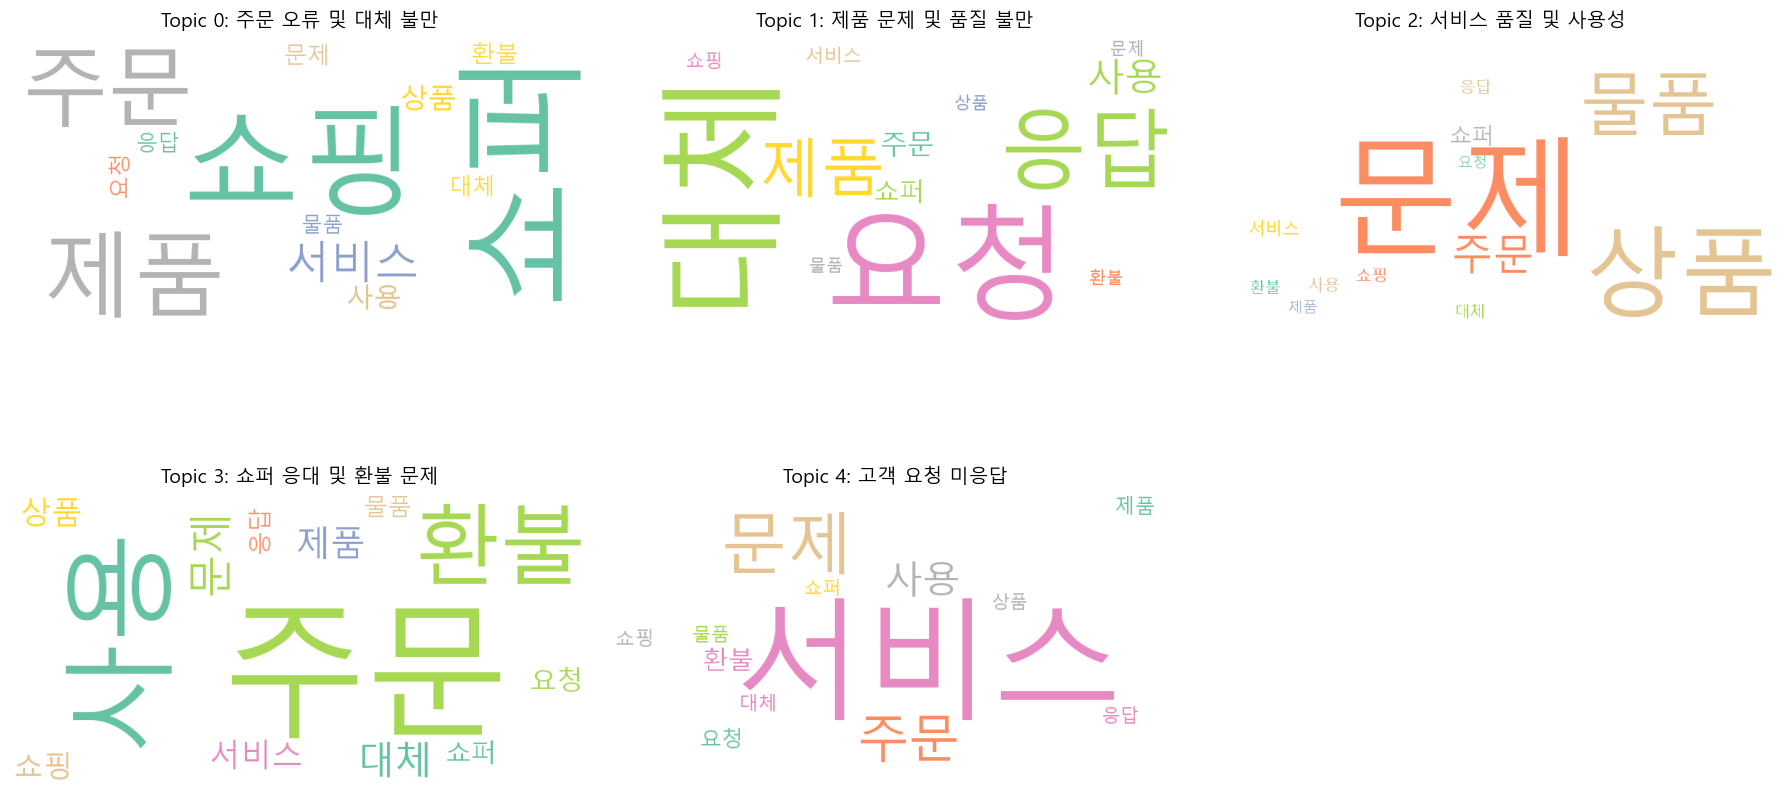

In [119]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 📌 폰트 설정 (윈도우의 경우)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 📌 수작업 주제명 매핑 (LDA topic 번호 ↔ 라벨)
topic_labels = {
    0: "주문 오류 및 대체 불만",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}

# 📌 시각화 레이아웃
n_topics = len(topic_labels)
ncols = 3
nrows = (n_topics + ncols - 1) // ncols

plt.figure(figsize=(18, 10))

# 📌 WordCloud 생성 및 시각화
for i, (topic_id, topic) in enumerate(lda_model.show_topics(formatted=False, num_words=20)):
    words = dict(topic)
    
    wc = WordCloud(
        font_path=font_path,
        background_color="white",
        colormap='Set2',
        width=800,
        height=400
    )

    plt.subplot(nrows, ncols, i + 1)
    plt.imshow(wc.generate_from_frequencies(words))
    plt.axis('off')
    title_text = f"Topic {topic_id}: {topic_labels.get(topic_id, 'Unknown')}"
    plt.title(title_text, fontproperties=font_prop, fontsize=14)

plt.tight_layout()
plt.show()


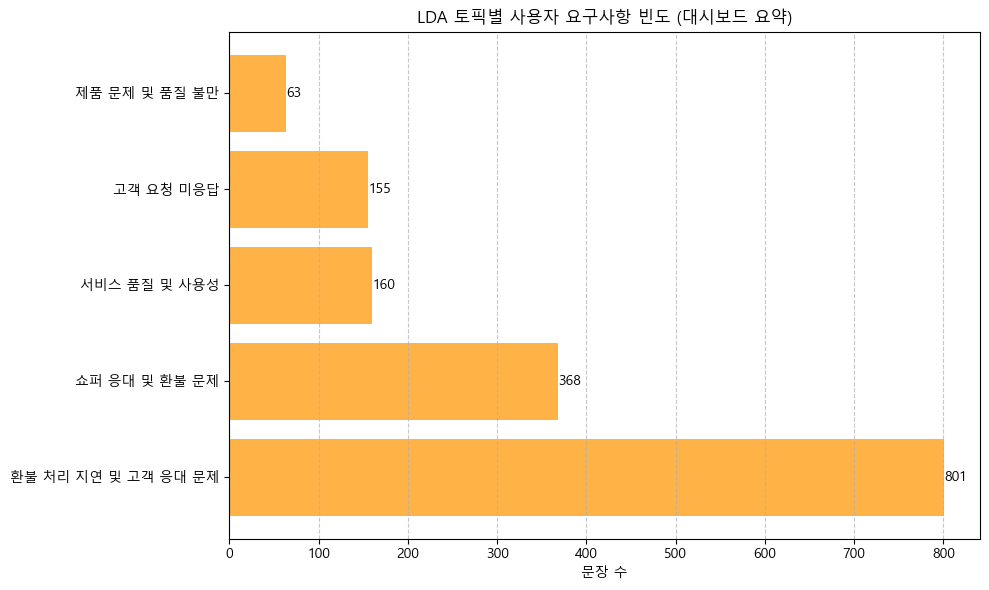

In [121]:
import matplotlib.pyplot as plt

# 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'

# ✅ LDA 토픽 라벨 정의 (lda_model 기반으로 분류된 토픽 번호와 매핑)
lda_topic_labels = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}

# ✅ LDA 기반 문장 수 요약 테이블
lda_summary = df_filtered['topic_cluster'].map(lda_topic_labels).value_counts().reset_index()
lda_summary.columns = ['토픽 주제', '문장 수']
lda_summary = lda_summary.sort_values('문장 수')  # y축 뒤집기용

# ✅ 수평 막대그래프 그리기
plt.figure(figsize=(10, 6))
bars = plt.barh(lda_summary['토픽 주제'], lda_summary['문장 수'], color="#FFB347")
plt.xlabel("문장 수")
plt.title("LDA 토픽별 사용자 요구사항 빈도 (대시보드 요약)")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# ✅ 바 라벨 추가
for bar in bars:
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
             f"{int(bar.get_width())}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


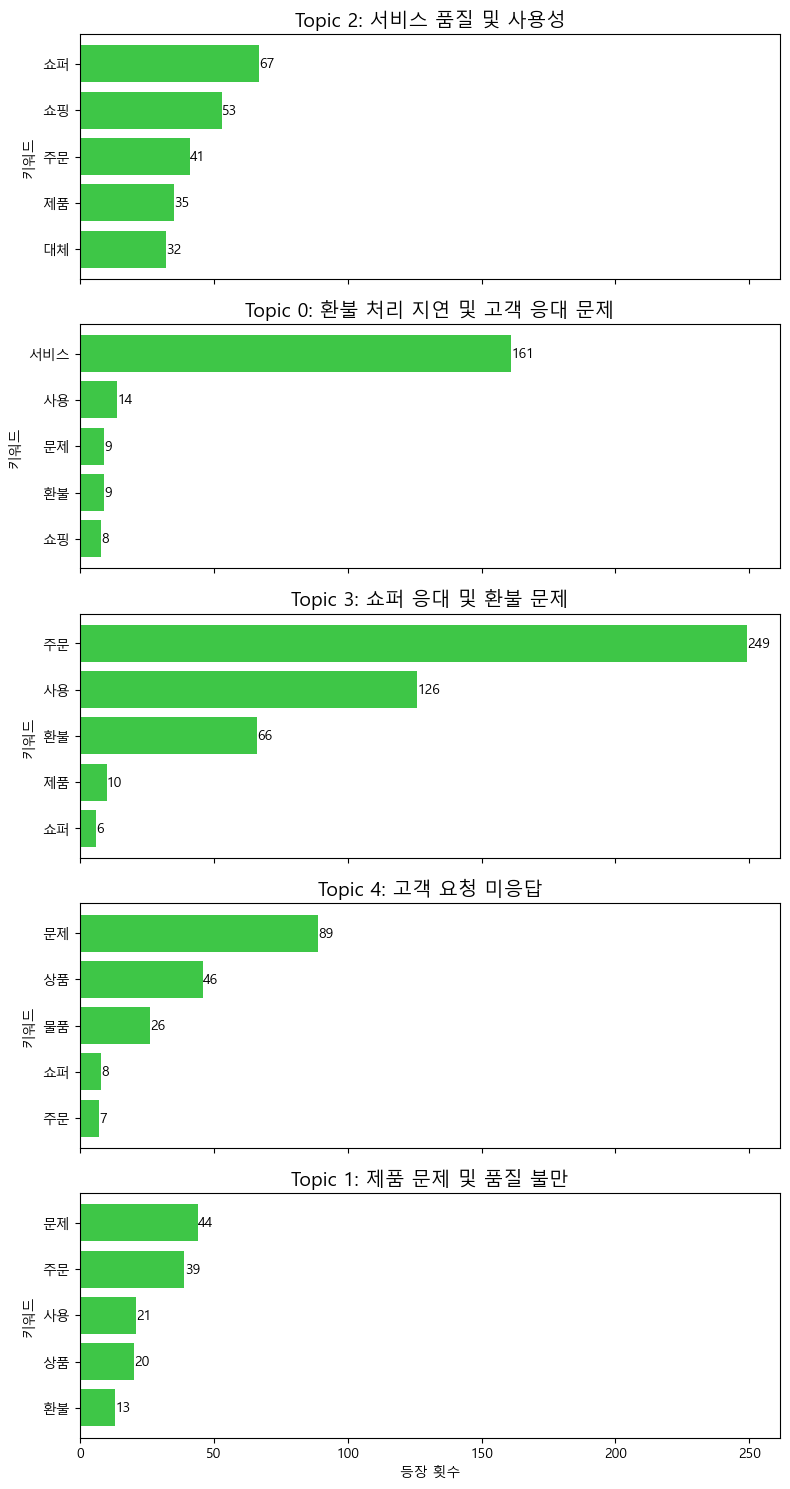

In [123]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# ✅ 한글 폰트 설정 (Windows 기준)
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# ✅ 토픽별 라벨 (lda_model 결과 기반)
lda_topic_labels = {
    0: "환불 처리 지연 및 고객 응대 문제",
    1: "제품 문제 및 품질 불만",
    2: "서비스 품질 및 사용성",
    3: "쇼퍼 응대 및 환불 문제",
    4: "고객 요청 미응답"
}

# ✅ 고빈도 키워드 시각화용 데이터프레임
clusters = df_top_keywords_lda['토픽'].unique()
num_clusters = len(clusters)

# ✅ subplot 구성
fig, axes = plt.subplots(num_clusters, 1, figsize=(8, 3 * num_clusters), sharex=True)

# subplot이 1개인 경우 리스트로 처리
if num_clusters == 1:
    axes = [axes]

# ✅ 각 토픽별 키워드 막대그래프
for i, topic_id in enumerate(clusters):
    data = df_top_keywords_lda[df_top_keywords_lda['토픽'] == topic_id]
    bars = axes[i].barh(data['키워드'], data['등장 횟수'], color="#3EC647")
    
    # 제목: LDA 토픽 라벨명으로 매핑
    title = f"Topic {topic_id}: {lda_topic_labels.get(topic_id, f'Topic {topic_id}')}"
    axes[i].set_title(title, fontproperties=font_prop, fontsize=14)
    axes[i].set_ylabel("키워드", fontproperties=font_prop)
    axes[i].invert_yaxis()

    # 각 막대 위에 숫자 표시
    for bar in bars:
        width = bar.get_width()
        axes[i].text(width + 0.1, bar.get_y() + bar.get_height() / 2,
                     f"{int(width)}", va='center', fontsize=10, color='black')

# ✅ 마지막 subplot에만 x축 레이블
axes[-1].set_xlabel("등장 횟수", fontproperties=font_prop)

plt.tight_layout()
plt.show()


In [126]:
df_filtered.to_csv("df_filtered_LDA분류포함.csv", index=False, encoding='utf-8-sig')
print("✅ LDA 결과 포함된 df_filtered 파일이 저장되었습니다.")

✅ LDA 결과 포함된 df_filtered 파일이 저장되었습니다.
